In [101]:
import pandas as pd
import numpy as np
import psycopg2
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


sqluser = 'postgres'
dbname = 'mimic'
schema_name = 'mimiciii'

# Password keyword only necessary if user-specified password required to connect to database
con = psycopg2.connect(dbname=dbname, user=sqluser, password='postgre')
cur = con.cursor()

query = "SELECT" \
        " a.subject_id, a.hadm_id, a.ethnicity, a.insurance, p.gender" \
        ", ROUND( (cast(a.admittime as date) - cast(p.dob as date)) / 365.242)" \
        " AS age_on_admiss" \
        ", cast(a.dischtime as date) - cast(a.admittime as date)" \
        " AS length_of_stay" \
        " FROM admissions a" \
        " INNER JOIN patients p" \
        " ON p.subject_id = a.subject_id" \
        " GROUP BY" \
        " a.subject_id, a.hadm_id, a.ethnicity, a.insurance, p.gender, a.admittime, p.dob, a.dischtime" \
        " ORDER BY a.subject_id;"

cur.execute('SET search_path to ' + schema_name)
df = pd.read_sql_query(query, con)

print(df.head(5))

   subject_id  hadm_id ethnicity insurance gender  age_on_admiss  \
0           2   163353     ASIAN   Private      M            0.0   
1           3   145834     WHITE  Medicare      M           77.0   
2           4   185777     WHITE   Private      F           48.0   
3           5   178980     ASIAN   Private      M            0.0   
4           6   107064     WHITE  Medicare      F           66.0   

   length_of_stay  
0               4  
1              11  
2               7  
3               2  
4              16  


## Pulling in CHARTEVENTS and LABEVENTS data

In [3]:
%%time
# Pulling in vital signs data
# Code adapted from https://github.com/MIT-LCP/mimic-code/blob/master/concepts/pivot/pivoted-vital.sql

query_vitals = """ with ce as
(
  select ce.hadm_id
    , ce.charttime
    , (case when itemid in (211,220045) and valuenum > 0 and valuenum < 300 then valuenum else null end) as HeartRate
    , (case when itemid in (51,442,455,6701,220179,220050) and valuenum > 0 and valuenum < 400 then valuenum else null end) as SysBP
    , (case when itemid in (615,618,220210,224690) and valuenum > 0 and valuenum < 70 then valuenum else null end) as RespRate
    , (case when itemid in (223761,678) and valuenum > 70 and valuenum < 120 then (valuenum-32)/1.8 -- converted to degC in valuenum call
               when itemid in (223762,676) and valuenum > 10 and valuenum < 50  then valuenum else null end) as TempC
    , (case when itemid in (646,220277) and valuenum > 0 and valuenum <= 100 then valuenum else null end) as SpO2
  from mimiciii.chartevents ce
  -- exclude rows marked as error
  where ce.error IS DISTINCT FROM 1
  and ce.itemid in
  (
  -- HEART RATE
  211, --"Heart Rate"
  220045, --"Heart Rate"

  -- Systolic

  51, --	Arterial BP [Systolic]
  442, --	Manual BP [Systolic]
  455, --	NBP [Systolic]
  6701, --	Arterial BP #2 [Systolic]
  220179, --	Non Invasive Blood Pressure systolic
  220050, --	Arterial Blood Pressure systolic

  -- RESPIRATORY RATE
  618,--	Respiratory Rate
  615,--	Resp Rate (Total)
  220210,--	Respiratory Rate
  224690, --	Respiratory Rate (Total)


  -- SPO2, peripheral
  646, 220277,


  -- TEMPERATURE
  223762, -- "Temperature Celsius"
  676,	-- "Temperature C"
  223761, -- "Temperature Fahrenheit"
  678 --	"Temperature F"

  )
)
select
    ce.hadm_id
  , ce.charttime
  , avg(HeartRate) as HeartRate
  , avg(SysBP) as SysBP
  , avg(RespRate) as RespRate
  , avg(TempC) as TempC
  , avg(SpO2) as SpO2
from ce
group by ce.hadm_id, ce.charttime
order by ce.hadm_id, ce.charttime;"""

df_vitals = pd.read_sql_query(query_vitals, con)

print(df_vitals.head(5))

   hadm_id           charttime  heartrate  sysbp  resprate      tempc  spo2
0   100001 2117-09-11 12:57:00      122.0    NaN      14.0        NaN   NaN
1   100001 2117-09-11 13:00:00      118.0    NaN      22.0        NaN   NaN
2   100001 2117-09-11 13:01:00        NaN  192.0       NaN        NaN   NaN
3   100001 2117-09-11 13:48:00        NaN    NaN       NaN  36.666667   NaN
4   100001 2117-09-11 13:50:00      118.0    NaN      22.0        NaN   NaN
Wall time: 15min 26s


In [4]:
df_vitals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8627341 entries, 0 to 8627340
Data columns (total 7 columns):
hadm_id      int64
charttime    datetime64[ns]
heartrate    float64
sysbp        float64
resprate     float64
tempc        float64
spo2         float64
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 460.7 MB


In [32]:
%%time
# Pulling in lab data
# Code adapted from https://github.com/MIT-LCP/mimic-code/blob/master/concepts/pivot/pivoted-lab.sql, added RDW values

query_lab = """
SELECT
    pvt.hadm_id, pvt.charttime
  , avg(CASE WHEN label = 'BILIRUBIN' THEN valuenum ELSE null END) as BILIRUBIN
  , avg(CASE WHEN label = 'CREATININE' THEN valuenum ELSE null END) as CREATININE
  , avg(CASE WHEN label = 'HEMATOCRIT' THEN valuenum ELSE null END) as HEMATOCRIT
  , avg(CASE WHEN label = 'HEMOGLOBIN' THEN valuenum ELSE null END) as HEMOGLOBIN
  , avg(CASE WHEN label = 'LACTATE' THEN valuenum ELSE null END) as LACTATE
  , avg(CASE WHEN label = 'PLATELET' THEN valuenum ELSE null END) as PLATELET
  , avg(CASE WHEN label = 'PTT' THEN valuenum ELSE null END) as PTT
  , avg(CASE WHEN label = 'INR' THEN valuenum ELSE null END) as INR
  , avg(CASE WHEN label = 'WBC' THEN valuenum ELSE null end) as WBC
  , avg(CASE WHEN label = 'RDW' THEN valuenum ELSE null end) as RDW
FROM
( -- begin query that extracts the data
  SELECT le.hadm_id, le.charttime
  -- here we assign labels to ITEMIDs
  -- this also fuses together multiple ITEMIDs containing the same data
  , CASE
        WHEN itemid = 50885 THEN 'BILIRUBIN'
        WHEN itemid = 50912 THEN 'CREATININE'
        WHEN itemid = 50810 THEN 'HEMATOCRIT'
        WHEN itemid = 51221 THEN 'HEMATOCRIT'
        WHEN itemid = 50811 THEN 'HEMOGLOBIN'
        WHEN itemid = 51222 THEN 'HEMOGLOBIN'
        WHEN itemid = 50813 THEN 'LACTATE'
        WHEN itemid = 51265 THEN 'PLATELET'
        WHEN itemid = 51275 THEN 'PTT'
        WHEN itemid = 51237 THEN 'INR'
        WHEN itemid = 51300 THEN 'WBC'
        WHEN itemid = 51301 THEN 'WBC'
        WHEN itemid = 51277 THEN 'RDW'
      ELSE null
    END AS label
  , -- add in some sanity checks on the values
  -- the where clause below requires all valuenum to be > 0, so these are only upper limit checks
    CASE
      WHEN itemid = 50885 and valuenum >   150 THEN null -- mg/dL 'BILIRUBIN'
      WHEN itemid = 50912 and valuenum >   150 THEN null -- mg/dL 'CREATININE'
      WHEN itemid = 50810 and valuenum >   100 THEN null -- % 'HEMATOCRIT'
      WHEN itemid = 51221 and valuenum >   100 THEN null -- % 'HEMATOCRIT'
      WHEN itemid = 50811 and valuenum >    50 THEN null -- g/dL 'HEMOGLOBIN'
      WHEN itemid = 51222 and valuenum >    50 THEN null -- g/dL 'HEMOGLOBIN'
      WHEN itemid = 50813 and valuenum >    50 THEN null -- mmol/L 'LACTATE'
      WHEN itemid = 51265 and valuenum > 10000 THEN null -- K/uL 'PLATELET'
      WHEN itemid = 51275 and valuenum >   150 THEN null -- sec 'PTT'
      WHEN itemid = 51237 and valuenum >    50 THEN null -- 'INR'
      WHEN itemid = 51300 and valuenum >  1000 THEN null -- 'WBC'
      WHEN itemid = 51301 and valuenum >  1000 THEN null -- 'WBC'
      WHEN itemid = 51277 and valuenum >   100 THEN null -- % 'RDW'
    ELSE le.valuenum
    END AS valuenum
  FROM labevents le
  WHERE le.ITEMID in
  (
    -- comment is: LABEL | CATEGORY | FLUID | NUMBER OF ROWS IN LABEVENTS
    50885, -- BILIRUBIN, TOTAL | CHEMISTRY | BLOOD | 238277
    50912, -- CREATININE | CHEMISTRY | BLOOD | 797476
    51221, -- HEMATOCRIT | HEMATOLOGY | BLOOD | 881846
    50810, -- HEMATOCRIT, CALCULATED | BLOOD GAS | BLOOD | 89715
    51222, -- HEMOGLOBIN | HEMATOLOGY | BLOOD | 752523
    50811, -- HEMOGLOBIN | BLOOD GAS | BLOOD | 89712
    50813, -- LACTATE | BLOOD GAS | BLOOD | 187124
    51265, -- PLATELET COUNT | HEMATOLOGY | BLOOD | 778444
    51275, -- PTT | HEMATOLOGY | BLOOD | 474937
    51237, -- INR(PT) | HEMATOLOGY | BLOOD | 471183
    51301, -- WHITE BLOOD CELLS | HEMATOLOGY | BLOOD | 753301
    51300, -- WBC COUNT | HEMATOLOGY | BLOOD | 2371
    51277  -- RDW | HEMATOLOGY | BLOOD | 746817
  )
  AND valuenum IS NOT NULL AND valuenum > 0 -- lab values cannot be 0 and cannot be negative
) pvt
GROUP BY pvt.hadm_id, pvt.charttime
ORDER BY pvt.hadm_id, pvt.charttime;"""

df_lab = pd.read_sql_query(query_lab, con)

print(df_lab.head(5))

    hadm_id           charttime  bilirubin  creatinine  hematocrit  \
0  100001.0 2117-09-11 08:22:00        0.5         2.7        36.5   
1  100001.0 2117-09-11 08:32:00        NaN         NaN         NaN   
2  100001.0 2117-09-11 09:24:00        NaN         NaN         NaN   
3  100001.0 2117-09-11 10:32:00        NaN         2.5         NaN   
4  100001.0 2117-09-11 14:50:00        NaN         2.3         NaN   

   hemoglobin  lactate  platelet   ptt  inr   wbc   rdw  
0        13.0      NaN     466.0   NaN  NaN  11.9  13.6  
1         NaN      1.9       NaN   NaN  NaN   NaN   NaN  
2         NaN      NaN       NaN  27.0  1.0   NaN   NaN  
3         NaN      NaN       NaN   NaN  NaN   NaN   NaN  
4         NaN      NaN       NaN   NaN  NaN   NaN   NaN  
Wall time: 1min 49s


In [33]:
df_lab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1379506 entries, 0 to 1379505
Data columns (total 12 columns):
hadm_id       1128033 non-null float64
charttime     1379506 non-null datetime64[ns]
bilirubin     237774 non-null float64
creatinine    794882 non-null float64
hematocrit    967387 non-null float64
hemoglobin    838257 non-null float64
lactate       187013 non-null float64
platelet      775825 non-null float64
ptt           473092 non-null float64
inr           470161 non-null float64
wbc           750953 non-null float64
rdw           744128 non-null float64
dtypes: datetime64[ns](1), float64(11)
memory usage: 126.3 MB


In [39]:
# Dropping rows where hadm_id is null

df2_lab = df_lab.dropna(axis=0, how='any', subset=['hadm_id'])
df2_lab.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1128033 entries, 0 to 1128032
Data columns (total 12 columns):
hadm_id       1128033 non-null float64
charttime     1128033 non-null datetime64[ns]
bilirubin     173784 non-null float64
creatinine    619458 non-null float64
hematocrit    778954 non-null float64
hemoglobin    662224 non-null float64
lactate       177956 non-null float64
platelet      598837 non-null float64
ptt           402346 non-null float64
inr           378278 non-null float64
wbc           577532 non-null float64
rdw           572042 non-null float64
dtypes: datetime64[ns](1), float64(11)
memory usage: 111.9 MB


### What is the average number of each type of measurement per stay?

In [89]:
def labStats(feature):
    df_labStat = df2_lab[['hadm_id', feature]]
    labStat_sorted = df_labStat.set_index('hadm_id').sort_index()
    labStat_grouped = labStat_sorted.groupby(labStat_sorted.index).count()
    print('Ave. number of', feature, 'measurements per hospital stay:', labStat_grouped.mean()[0])
    print('Std. dev of', feature, 'measurements per hospital stay:', labStat_grouped.std()[0])
    print('Min. number of', feature, 'measurements per hospital stay:', labStat_grouped.min()[0])
    print('Max. number of', feature, 'measurements per hospital stay:', labStat_grouped.max()[0])
    return labStat_grouped.head()

for i in df_lab.columns[2:]:
    print(labStats(i))

Ave. number of bilirubin measurements per hospital stay: 2.991685172752156
Std. dev of bilirubin measurements per hospital stay: 6.69231124103759
Min. number of bilirubin measurements per hospital stay: 0
Max. number of bilirubin measurements per hospital stay: 191
          bilirubin
hadm_id            
100001.0          1
100003.0          5
100006.0          0
100007.0          1
100009.0          1
Ave. number of creatinine measurements per hospital stay: 10.66394670247379
Std. dev of creatinine measurements per hospital stay: 13.123923938928339
Min. number of creatinine measurements per hospital stay: 0
Max. number of creatinine measurements per hospital stay: 351
          creatinine
hadm_id             
100001.0          14
100003.0           6
100006.0          13
100007.0           9
100009.0           6
Ave. number of hematocrit measurements per hospital stay: 13.409664480366335
Std. dev of hematocrit measurements per hospital stay: 15.64153640272455
Min. number of hematocrit

Looks like there is large variation in terms of number of each measurement per hospital stay.

## Distributions for lab features

AxesSubplot(0.125,0.125;0.775x0.755)


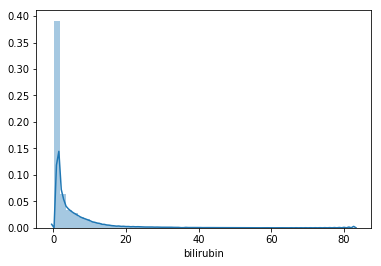

AxesSubplot(0.125,0.125;0.775x0.755)


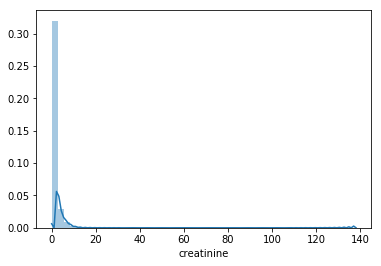

AxesSubplot(0.125,0.125;0.775x0.755)


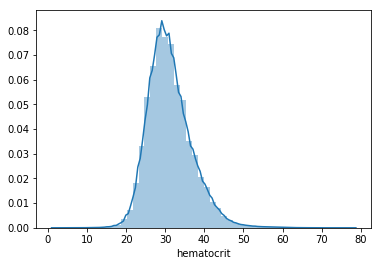

AxesSubplot(0.125,0.125;0.775x0.755)


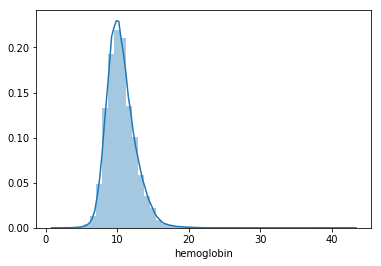

AxesSubplot(0.125,0.125;0.775x0.755)


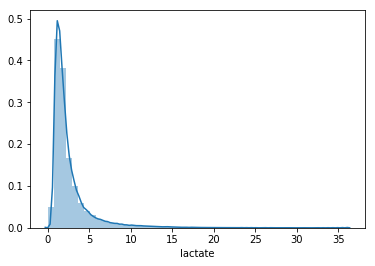

AxesSubplot(0.125,0.125;0.775x0.755)


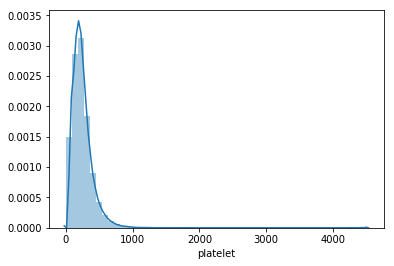

AxesSubplot(0.125,0.125;0.775x0.755)


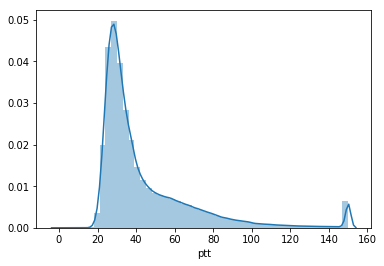

AxesSubplot(0.125,0.125;0.775x0.755)


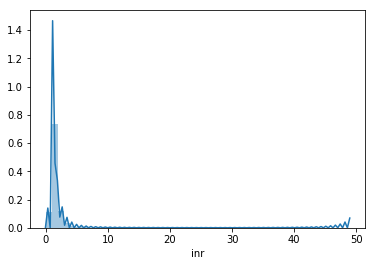

AxesSubplot(0.125,0.125;0.775x0.755)


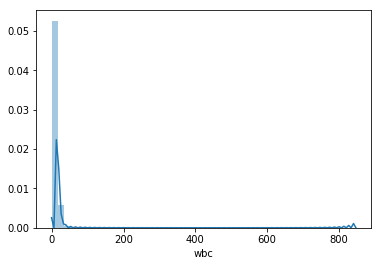

AxesSubplot(0.125,0.125;0.775x0.755)


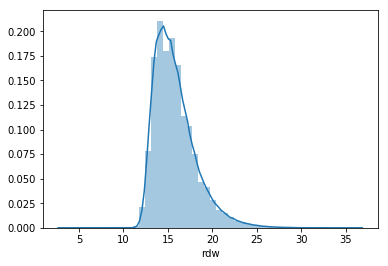

In [104]:
def labDistr(feature):
    feature_data = df_lab[feature].dropna()
    plt.figure()
    plt.show()
    return sns.distplot(feature_data)

for i in df_lab.columns[2:]:
    print(labDistr(i))

## Pulling in prescription data

In [14]:
%%time
# Creating one dataframe per drug (we can consolidate after feature selection?)

def query_prescrip(drug_desc):
    general_query = """ 
        SELECT p.subject_id, p.hadm_id, p.startdate, p.enddate,
        p.drug, p.drug_name_poe, p.drug_name_generic, a.admittime, a.dischtime
        FROM mimiciii.prescriptions p
        INNER JOIN mimiciii.admissions a
        ON p.hadm_id = a.hadm_id
        WHERE startdate < dischtime
        AND """
    drug_specific = drug_desc
    whole_query = general_query + drug_specific
    return pd.read_sql_query(whole_query, con)

# Vancomycin and neo-synephrine require special queries
df_vanco = query_prescrip("""(lower(drug) LIKE '%vancomycin%' 
OR lower(drug) LIKE '%vancocin%' 
OR lower(drug_name_poe) LIKE '%vancomycin%'
OR lower(drug_name_generic) LIKE '%vancomycin%');""")

df_neosyn = query_prescrip("""(lower(drug) LIKE 'neo%ephrine%'
      OR lower(drug) LIKE 'phenylephrine%');""")

# Other drugs use same query format
def gen_drug_desc(drug):
    gen_drug_query = "(lower(drug) LIKE '%" + drug + "%' OR lower(drug_name_poe) LIKE '%"\
                        + drug + "%' OR lower(drug_name_generic) LIKE '%" + drug + "%');"
    return gen_drug_query

df_neostig = query_prescrip(gen_drug_desc('neostigmine'))
df_glycopyr = query_prescrip(gen_drug_desc('glycopyrrolate'))
df_ceftriax = query_prescrip(gen_drug_desc('ceftriaxone'))
df_atropsulf = query_prescrip(gen_drug_desc('atropine sulfate'))
df_chlorhex = query_prescrip(gen_drug_desc('chlorhexidine'))
df_nitroglyc = query_prescrip(gen_drug_desc('nitroglycerin'))
df_nitropruss = query_prescrip(gen_drug_desc('nitroprusside'))
df_lansopraz = query_prescrip(gen_drug_desc('lansoprazole'))
    

#df_vanco = query_prescrip(vanco_desc)
#query_prescrip(neosyn_desc)


Wall time: 45 s


In [24]:
# How many rows in each dataframe?

#drug_list = ['vancomycin', 'neosynephrine', 'neostigmine', 'glycopyrrolate', 'ceftriaxone', 
#'atropine sulfate', 'chlorhexidine', 'nitroglycerin', 'nitroprusside', 'lansoprazole']
print('vancomycin:', df_vanco.shape[0], 'rows')
print('neosynephrine:', df_neosyn.shape[0], 'rows')
print('neostigmine:', df_neostig.shape[0], 'rows')
print('glycopyrrolate:', df_glycopyr.shape[0], 'rows')
print('ceftriaxone:', df_ceftriax.shape[0], 'rows')
print('atropine sulfate:', df_atropsulf.shape[0], 'rows')
print('chlorhexidine:', df_chlorhex.shape[0], 'rows')
print('nitroglycerin:', df_nitroglyc.shape[0], 'rows')
print('nitroprusside:', df_nitropruss.shape[0], 'rows')
print('lansoprazole:', df_lansopraz.shape[0], 'rows')

vancomycin: 68734 rows
neosynephrine: 22312 rows
neostigmine: 6812 rows
glycopyrrolate: 8036 rows
ceftriaxone: 8722 rows
atropine sulfate: 5119 rows
chlorhexidine: 12124 rows
nitroglycerin: 21892 rows
nitroprusside: 4896 rows
lansoprazole: 7424 rows


## Pulling in procedure data

In [27]:
%%time
# Creating one dataframe per procedure (we can consolidate after feature selection?)

def query_proc(proc_desc):
    general_query = """ 
        SELECT pr.subject_id, pr.hadm_id, d.icd9_code, d.short_title, d.long_title
        FROM mimiciii.procedures_icd pr
        INNER JOIN mimiciii.d_icd_procedures d
        ON pr.icd9_code = d.icd9_code
        WHERE """
    proc_specific = proc_desc
    whole_query = general_query + proc_specific
    return pd.read_sql_query(whole_query, con)

df_parentinf = query_proc("short_title = 'Parent infus nutrit sub';")
df_serumtransf = query_proc("short_title = 'Serum transfusion NEC';")
df_skinsut = query_proc("short_title = 'Skin closure NEC';")
df_vasopress = query_proc("short_title = 'Infusion of vasopressor';")
df_mammCAB = query_proc("short_title = '1 int mam-cor art bypass';")
df_aortoCBT = query_proc("short_title = 'Aortocor bypas-2 cor art' OR short_title = 'Aortocor bypas-3 cor art';")
df_platetransf = query_proc("short_title = 'Platelet transfusion';")
df_intercath = query_proc("short_title = 'Insert intercostal cath';")

Wall time: 148 ms


In [30]:
# How many rows in each dataframe?

print('parenteral infusion:', df_parentinf.shape[0], 'rows')
print('serum transfusion:', df_serumtransf.shape[0], 'rows')
print('skin suture:', df_skinsut.shape[0], 'rows')
print('infusion of vasopressor:', df_vasopress.shape[0], 'rows')
print('single internal mammary-coronary artery bypass:', df_mammCAB.shape[0], 'rows')
print('aortocoronary bypass T:', df_aortoCBT.shape[0], 'rows')
print('platelet transfusion:', df_platetransf.shape[0], 'rows')
print('insertion of intercostal catheter:', df_intercath.shape[0], 'rows')


parenteral infusion: 4244 rows
serum transfusion: 2028 rows
skin suture: 719 rows
infusion of vasopressor: 832 rows
single internal mammary-coronary artery bypass: 4401 rows
aortocoronary bypass T: 3407 rows
platelet transfusion: 1235 rows
insertion of intercostal catheter: 1717 rows


## Merging dataframes

In [26]:
merge_df = df.merge(df_vitals, on = "hadm_id", how = "inner")

In [27]:
merge_df.head(5)

,subject_id,hadm_id,ethnicity,insurance,gender,age_on_admiss,length_of_stay,charttime,heartrate,sysbp,resprate,tempc,spo2
0,2,163353,ASIAN,Private,M,0.0,4,2138-07-17 20:20:00,148.0,NaN,NaN,NaN,NaN
1,2,163353,ASIAN,Private,M,0.0,4,2138-07-17 20:30:00,131.0,NaN,NaN,NaN,NaN
2,2,163353,ASIAN,Private,M,0.0,4,2138-07-17 21:00:00,144.0,NaN,NaN,NaN,NaN
3,2,163353,ASIAN,Private,M,0.0,4,2138-07-17 22:00:00,140.0,NaN,NaN,NaN,NaN
4,3,145834,WHITE,Medicare,M,77.0,11,2101-10-20 18:30:00,NaN,NaN,NaN,36.055556,NaN


In [28]:
merge_df.isnull().sum()

subject_id              0
hadm_id                 0
ethnicity               0
insurance               0
gender                  0
age_on_admiss           0
length_of_stay          0
charttime               0
heartrate          688687
sysbp             2844883
resprate          2350596
tempc             6892769
spo2              2542725
dtype: int64

In [29]:
merge_df.shape

(8627341, 13)

In [30]:
merge_df.describe()

,subject_id,hadm_id,age_on_admiss,length_of_stay,heartrate,sysbp,resprate,tempc,spo2
count,8.627341e+06,8.627341e+06,8.627341e+06,8.627341e+06,7.938654e+06,5.782458e+06,6.276745e+06,1.734572e+06,6.084616e+06
mean,3.300434e+04,1.498434e+05,5.897300e+01,2.766516e+01,1.014212e+02,1.215081e+02,2.020785e+01,3.700469e+01,9.708009e+01
std,2.785872e+04,2.874910e+04,5.305239e+01,2.898572e+01,3.279940e+01,2.368802e+01,6.043783e+00,8.432616e-01,3.495221e+00
min,2.000000e+00,1.000010e+05,0.000000e+00,0.000000e+00,1.460000e-01,6.000000e-02,1.700000e-01,1.500000e+01,5.000000e-01
25%,1.156300e+04,1.253430e+05,3.700000e+01,9.000000e+00,7.800000e+01,1.040000e+02,1.600000e+01,3.644444e+01,9.600000e+01
50%,2.348300e+04,1.491550e+05,6.100000e+01,1.800000e+01,9.200000e+01,1.190000e+02,2.000000e+01,3.700000e+01,9.800000e+01
75%,5.255000e+04,1.749130e+05,7.500000e+01,3.500000e+01,1.190000e+02,1.370000e+02,2.400000e+01,3.755555e+01,9.900000e+01
max,9.999900e+04,1.999990e+05,3.100000e+02,2.950000e+02,2.920000e+02,3.550000e+02,6.900000e+01,4.650000e+01,1.000000e+02


In [36]:
merge_agg_df = merge_df.groupby('hadm_id').agg('mean')


In [31]:
list(merge_df)

['subject_id',
 'hadm_id',
 'ethnicity',
 'insurance',
 'gender',
 'age_on_admiss',
 'length_of_stay',
 'charttime',
 'heartrate',
 'sysbp',
 'resprate',
 'tempc',
 'spo2']

In [37]:
merge_agg_df.isnull().sum()

subject_id           0
age_on_admiss        0
length_of_stay       0
heartrate           12
sysbp             7693
resprate          7708
tempc             7825
spo2              7727
dtype: int64

In [38]:
merge_agg_df.describe()

,subject_id,age_on_admiss,length_of_stay,heartrate,sysbp,resprate,tempc,spo2
count,56725.000000,56725.000000,56725.000000,56713.000000,49032.000000,49017.000000,48900.000000,48998.000000
mean,33889.740467,64.718431,10.221966,92.589150,120.829083,19.118249,36.833328,96.879525
std,28162.107130,57.375131,12.562837,24.235403,16.310950,3.594148,0.546761,2.429015
min,2.000000,0.000000,0.000000,29.916667,29.166667,7.000000,30.000000,31.444444
25%,12028.000000,44.000000,4.000000,76.681818,109.244127,16.560606,36.501409,96.045455
50%,24204.000000,62.000000,7.000000,86.863636,119.056187,18.685039,36.819444,97.200000
75%,54247.000000,76.000000,12.000000,100.232955,131.143908,21.233129,37.162901,98.205128
max,99999.000000,310.000000,295.000000,244.800000,215.833333,45.500000,40.833333,100.000000


In [43]:
(merge_agg_df.isnull().sum()/merge_agg_df.count())* 100

subject_id         0.000000
age_on_admiss      0.000000
length_of_stay     0.000000
heartrate          0.021159
sysbp             15.689754
resprate          15.725157
tempc             16.002045
spo2              15.770031
dtype: float64

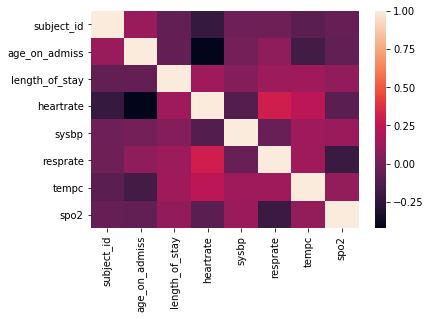

In [48]:
corr = merge_agg_df.corr()
sns.heatmap(corr)


/Users/michaelalbuquerque/anaconda/envs/mimic/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


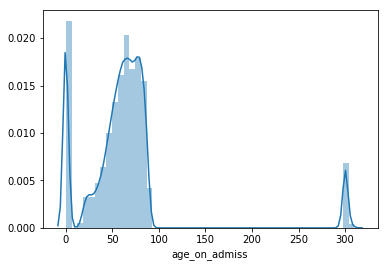

In [54]:
sns.distplot(merge_agg_df['age_on_admiss'])


In [56]:
merge_agg_df['age_on_admiss'] = np.where(merge_agg_df['age_on_admiss']>100, 90, merge_agg_df['age_on_admiss'])

/Users/michaelalbuquerque/anaconda/envs/mimic/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


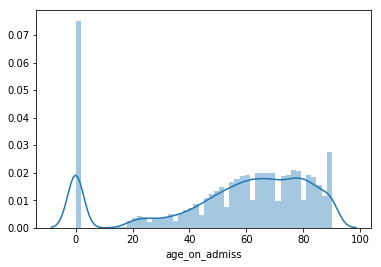

In [57]:
sns.distplot(merge_agg_df['age_on_admiss'])
